1. Vasudev Pareek
2. Manthan Patel
3. Ashish Pathak

Deliverables:
1. Implement ResNet model from scratch, alongwith custom ResNet blocks
2. Train it on cifar-10 from scratch with some hyperparameter tuning
3. Show some inferences

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Importing important libraries

In [ ]:
# Importing Libraries
import torch
import torch.nn as nn
import torchvision 
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np


Setting the devide CPU/GPU

In [ ]:
# Device will determine whether to run the training on GPU or CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

Downloading *CIFAR 10*, Pre-processing the image data & making Train and Test dataloaders  using  BATCHSIZE  = 128

In [ ]:
#Data Processing for CIFAR 10, defining number batch size and classes
transform = transforms.Compose(
                                    [
                                        transforms.Resize([32, 32]),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
                                    ]
                               )
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
batch_size = 128
no_of_classes = 10
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
trainset
#contains 50000 images

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=[32, 32], interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261))
           )

In [ ]:
testset
#contains 10000 images

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               Resize(size=[32, 32], interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261))
           )

Printing a grid of images 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


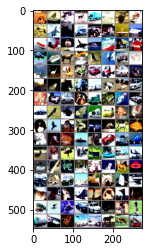

dog   bird  cat   deer  truck plane bird  cat   deer  plane cat   truck truck truck plane ship  ship  bird  bird  plane ship  ship  truck truck bird  ship  horse cat   bird  plane ship  dog   plane bird  dog   frog  car   truck car   frog  truck frog  horse car   truck cat   deer  car   frog  truck car   dog   truck frog  ship  car   car   bird  car   frog  dog   car   dog   bird  dog   bird  bird  truck car   frog  horse frog  dog   horse cat   ship  dog   car   truck car   deer  dog   bird  car   deer  car   plane plane cat   cat   frog  deer  dog   dog   horse car   truck frog  car   ship  cat   dog   dog   ship  dog   cat   deer  truck bird  dog   bird  deer  frog  bird  plane car   car   deer  bird  bird  truck ship  frog  truck ship  horse deer  ship 


In [ ]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

Building a resBlock for ResNet

In [ ]:
#Building a resBlock for ResNet
class block(nn.Module):
    def __init__(self, in_channels, intermediate_channels, identity_downsample=None, stride=1):
        super(block, self).__init__()
        self.expansion = 4
        self.conv1 = nn.Conv2d(
            in_channels, 
            intermediate_channels, 
            kernel_size=1, 
            stride=1, 
            padding=0, 
            bias=False
        )
        self.bn1 = nn.BatchNorm2d(intermediate_channels)
        self.conv2 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False
        )
        self.bn2 = nn.BatchNorm2d(intermediate_channels)
        self.conv3 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels * self.expansion,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=False
        )
        self.bn3 = nn.BatchNorm2d(intermediate_channels * self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
        self.stride = stride

    def forward(self, x):
        identity = x.clone()

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x

Building the main architecture of ResNet

In [ ]:
class ResNet(nn.Module):
    def __init__(self, block, layers, image_channels, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Essentially the entire ResNet architecture are in these 4 lines below
        self.layer1 = self._make_layer(
            block, layers[0], intermediate_channels=64, stride=1
        )
        self.layer2 = self._make_layer(
            block, layers[1], intermediate_channels=128, stride=2
        )
        self.layer3 = self._make_layer(
            block, layers[2], intermediate_channels=256, stride=2
        )
        self.layer4 = self._make_layer(
            block, layers[3], intermediate_channels=512, stride=2
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x

    def _make_layer(self, block, num_residual_blocks, intermediate_channels, stride):
        identity_downsample = None
        layers = []

        # Either if we half the input space for ex, 56x56 -> 28x28 (stride=2), or channels changes
        # we need to adapt the Identity (skip connection) so it will be able to be added
        # to the layer that's ahead
        if stride != 1 or self.in_channels != intermediate_channels * 4:
            identity_downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels,
                    intermediate_channels * 4,
                    kernel_size=1,
                    stride=stride,
                    bias=False
                ),
                nn.BatchNorm2d(intermediate_channels * 4),
            )

        layers.append(
            block(self.in_channels, intermediate_channels, identity_downsample, stride)
        )

        # The expansion size is always 4 for ResNet 50,101,152
        self.in_channels = intermediate_channels * 4

        # For example for first resnet layer: 256 will be mapped to 64 as intermediate layer,
        # then finally back to 256. Hence no identity downsample is needed, since stride = 1,
        # and also same amount of channels.
        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, intermediate_channels))

        return nn.Sequential(*layers)

In [ ]:
def ResNet50(img_channel=3, num_classes=10):
    return ResNet(block, [3, 4, 6, 3], img_channel, num_classes)

In [ ]:
model = ResNet50(3,num_classes=10)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): block(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (identity_downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    

In [ ]:
learning_rate = 0.001
num_epochs = 30

In [ ]:
criterion = nn.CrossEntropyLoss()

# Set optimizer with optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)  
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
total_step = len(trainloader)

In [ ]:
torch.manual_seed(0)
losses = []
for epoch in range(num_epochs):
	#Load in the data in batches using the train_loader object
    for i, (images, labels) in enumerate(trainloader):  
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)  
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    scheduler.step()
    losses.append(loss.item())
    
    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

KeyboardInterrupt: ignored

In [ ]:
losses

In [ ]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.xlabel('No of epochs')
plt.ylabel('Training Loss')
plt.title('Loss Curve')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

df1 = pd.read_csv('/content/gdrive/MyDrive/NNFL Assignment-3/train_loss1.csv')
x = df1['epochs']
y = df1['losses']



In [ ]:

plt.plot(x, y)
plt.xlabel('No of epochs')
plt.ylabel('Training Loss')
plt.title('Loss Curve')
plt.show()

In [ ]:
# loading library
import pickle

In [ ]:
# pickle.dump(model, open("/content/gdrive/MyDrive/NNFL /model.pkl1", "wb"))

In [ ]:
 # load saved model
with open("/content/gdrive/MyDrive/NNFL Assignment-3/model_pkl1.pkl1", 'rb') as f:
    lr = pickle.load(f)

In [ ]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in trainloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = lr(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    print('Accuracy of the network on the {} train images: {} %'.format(50000, 100 * correct / total))

Accuracy of the network on the 50000 train images: 99.936 %


In [ ]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in testloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = lr(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    print('Accuracy of the network on the {} test images: {} %'.format(10000, 100 * correct / total))

Accuracy of the network on the 10000 test images: 62.38 %


In [ ]:
enumerate(trainloader)